In [46]:
import plotly
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

In [109]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import textwrap

class ComplexRadar:
    """Create a complex radar chart with different scales for each variable
    Args:
    fig (`matplotlib.figure`) :  A matplotlib figure object to add the axes on.
    variables (`list`) : a list of variables to. plot
    ranges (`list` of `tuples`): A list of ranges (min, max) for each variable
    n_ring_levels (`int): Number of ordinate or ring levels to draw.
        Default: 5.
    show_scales (`bool`): Indicates if we the ranges for each variable are plotted.
        Default: True.
    format_cfg (`dict`): A dictionary with formatting configurations.
        Default: None.
    Returns:
    `matplotlib.figure.Figure`: a radar plot.
    """

    def __init__(self, fig, variables, ranges, n_ring_levels=5, show_scales=True, format_cfg=None):

        self.format_cfg = format_cfg

        # Calculate angles and create for each variable an axes
        # Consider here the trick with having the first axes element twice (len+1)
        angles = np.arange(0, 360, 360.0 / len(variables))
        axes = [
            fig.add_axes([0.1, 0.1, 0.9, 0.9], polar=True, label="axes{}".format(i), **self.format_cfg["axes_args"])
            for i in range(len(variables) + 1)
        ]

        # Ensure clockwise rotation (first variable at the top N)
        for ax in axes:
            ax.set_theta_zero_location("N")
            ax.set_theta_direction(-1)
            ax.set_axisbelow(True)

        # Writing the ranges on each axes
        for i, ax in enumerate(axes):

            # Here we do the trick by repeating the first iteration
            j = 0 if (i == 0 or i == 1) else i - 1
            ax.set_ylim(*ranges[j])
            # Set endpoint to True if you like to have values right before the last circle
            grid = np.linspace(*ranges[j], num=n_ring_levels, endpoint=self.format_cfg["incl_endpoint"])
            gridlabel = ["{}".format(round(x, 2)) for x in grid]
            gridlabel[0] = ""  # remove values from the center
            lines, labels = ax.set_rgrids(
                grid, labels=gridlabel, angle=angles[j], **self.format_cfg["rgrid_tick_lbls_args"]
            )

            ax.set_ylim(*ranges[j])
            ax.spines["polar"].set_visible(False)
            ax.grid(visible=False)

            if show_scales is False:
                ax.set_yticklabels([])

        # Set all axes except the first one unvisible
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)

        # Setting the attributes
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
        self.ax1 = axes[1]
        self.plot_counter = 0

        # Draw (inner) circles and lines
        self.ax.yaxis.grid(**self.format_cfg["rad_ln_args"])
        # Draw outer circle
        self.ax.spines["polar"].set(**self.format_cfg["outer_ring"])
        # Draw angle lines
        self.ax.xaxis.grid(**self.format_cfg["angle_ln_args"])

        # ax1 is the duplicate of axes[0] (self.ax)
        # Remove everything from ax1 except the plot itself
        self.ax1.axis("off")
        self.ax1.set_zorder(9)

        # Create the outer labels for each variable
        l, text = self.ax.set_thetagrids(angles, labels=variables)

        # Beautify them
        labels = [t.get_text() for t in self.ax.get_xticklabels()]
        labels = [
            "\n".join(
                textwrap.wrap(
                    label,
                    self.format_cfg["theta_tick_lbls_txt_wrap"],
                    break_long_words=self.format_cfg["theta_tick_lbls_brk_lng_wrds"],
                )
            )
            for label in labels
        ]
        self.ax.set_xticklabels(labels, **self.format_cfg["theta_tick_lbls"])

        for t, a in zip(self.ax.get_xticklabels(), angles):
            if a == 0:
                t.set_ha("center")
            elif a > 0 and a < 180:
                t.set_ha("left")
            elif a == 180:
                t.set_ha("center")
            else:
                t.set_ha("right")

        self.ax.tick_params(axis="both", pad=self.format_cfg["theta_tick_lbls_pad"])

    def _scale_data(self, data, ranges):
        """Scales data[1:] to ranges[0]"""
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            assert (y1 <= d <= y2) or (y2 <= d <= y1)
        x1, x2 = ranges[0]
        d = data[0]
        sdata = [d]
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            sdata.append((d - y1) / (y2 - y1) * (x2 - x1) + x1)
        return sdata

    def plot(self, data, *args, **kwargs):
        """Plots a line"""
        sdata = self._scale_data(data, self.ranges)
        self.ax1.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kwargs)
        self.plot_counter = self.plot_counter + 1

    def use_legend(self, *args, **kwargs):
        """Shows a legend"""
        self.ax1.legend(*args, **kwargs)


def radar_plot(data, model_names, invert_range=[], config=None, fig=None):
    """Create a complex radar chart with different scales for each variable
    Source: https://towardsdatascience.com/how-to-create-and-visualize-complex-radar-charts-f7764d0f3652

    Args:
        data (`List[dict]`): the results (list of metric + value pairs).
            E.g. data = [{"accuracy": 0.9, "precision":0.8},{"accuracy": 0.7, "precision":0.6}]
        names (`List[dict]`): model names.
            E.g. names = ["model1", "model 2", ...]
        invert_range (`List[dict]`, optional): the metrics to invert (in cases when smaller is better, e.g. speed)
            E.g. invert_range=["latency_in_seconds"]
        config (`dict`, optional) : a specification of the formatting configurations, namely:

            - rad_ln_args (`dict`, default `{"visible": True}`): The visibility of the radial (circle) lines.

            - outer_ring (`dict`, default `{"visible": True}`): The visibility of the outer ring.

            - angle_ln_args (`dict`, default `{"visible": True}`): The visibility of the angle lines.

            - rgrid_tick_lbls_args (`dict`, default `{"fontsize": 12}`): The font size of the tick labels on the scales.

            - theta_tick_lbls (`dict`, default `{"fontsize": 12}`): The font size of the variable labels on the plot.

            - theta_tick_lbls_pad (`int`, default `3`): The padding of the variable labels on the plot.

            - theta_tick_lbls_brk_lng_wrds (`bool`, default `True` ): Whether long words in the label are broken up or not.

            - theta_tick_lbls_txt_wrap (`int`, default `15`): Text wrap for tick labels

            - incl_endpoint (`bool`, default `False`): Include value endpoints on calse

            - marker (`str`, default `"o"`): the shape of the marker used in the radar plot.

            - markersize (`int`, default `3`): the shape of the marker used in the radar plot.

            - legend_loc (`str`, default `"upper right"`): the location of the legend in the radar plot. Must be one of: 'upper left', 'upper right', 'lower left', 'lower right'.

            - bbox_to_anchor (`tuple`, default `(2, 1)`: anchor for the legend.
        fig (`matplotlib.figure.Figure`, optional): figure used to plot the radar plot.

    Returns:
        `matplotlib.figure.Figure`
    """
    data = pd.DataFrame(data)
    data.index = model_names
    variables = data.keys()
    if all(x in variables for x in invert_range) is False:
        raise ValueError("All of the metrics in `invert_range` should be in the data provided.")
    min_max_per_variable = data.describe().T[["min", "max"]]
    min_max_per_variable["min"] = min_max_per_variable["min"] - 0.1 * (
        min_max_per_variable["max"] - min_max_per_variable["min"]
    )
    min_max_per_variable["max"] = min_max_per_variable["max"] + 0.1 * (
        min_max_per_variable["max"] - min_max_per_variable["min"]
    )

    ranges = list(min_max_per_variable.itertuples(index=False, name=None))
    ranges = [
        (max_value, min_value) if var in invert_range else (min_value, max_value)
        for var, (min_value, max_value) in zip(variables, ranges)
    ]
    format_cfg = {
        "axes_args": {},
        "rad_ln_args": {"visible": True},
        "outer_ring": {"visible": True},
        "angle_ln_args": {"visible": True},
        "rgrid_tick_lbls_args": {"fontsize": 12},
        "theta_tick_lbls": {"fontsize": 12},
        "theta_tick_lbls_pad": 3,
        "theta_tick_lbls_brk_lng_wrds": True,
        "theta_tick_lbls_txt_wrap": 15,
        "incl_endpoint": False,
        "marker": "o",
        "markersize": 3,
        "legend_loc": "upper right",
        "bbox_to_anchor": (2, 1),
    }
    if config is not None:
        format_cfg.update(config)
    if fig is None:
        fig = plt.figure()
    radar = ComplexRadar(
        fig,
        variables,
        ranges,
        n_ring_levels=3,
        show_scales=True,
        format_cfg=format_cfg,
    )
    for g in zip(data.index):
        radar.plot(data.loc[g].values, label=g, marker=format_cfg["marker"], markersize=format_cfg["markersize"])
        radar.use_legend(**{"loc": format_cfg["legend_loc"], "bbox_to_anchor": format_cfg["bbox_to_anchor"]})
    return fig

In [104]:
rename = {'giant_mae_acav100M_40ms_10s-final-data=true-ep21=true-mode=amp-batch-size=256':'1.3B',
          'giant_mae_acav100M_40ms_10s-final-data=true-ep31=true-mode=amp-batch-size=256': '4B',
         }

In [105]:
from io import StringIO
df = pd.read_csv(StringIO("""
Beehive StatesF0	Beehive StatesF1	Beehive	Beijing Opera Percussion	CREMA-D	DCASE16	ESC-50	FSD50K	GTZAN Genre	GTZAN Music Speech	Gunshot Triangulation	LibriCount	MAESTRO 5hr	Mridangam Stroke	Mridangam Tonic	NSynth Pitch 50hr	NSynth Pitch 5hr	Speech Commands 5hr	Speech Commands Full	Vocal Imitations	VoxLingua107 Top10
giant_mae_acav100M_40ms_10s-final-data=true-ep21=true-mode=amp-batch-size=256	33.62	62.83	48.225	92.37	78.77	94.41	83.3	52.75	89.6	96.92	95.24	78.67	42.25	97.1	96.52	84.7	72.8	95.38	97.44	16.16	69.86
giant_mae_acav100M_40ms_10s-final-data=true-ep31=true-mode=amp-batch-size=256	38.9	64.41	51.655	95.35	80.16	93.45	84.4	53.74	88	97.69	90.77	78.48	42.64	97.1	96.55	85.39	74.4	96.63	97.65	16.84	72.33"""),sep='\t')

In [106]:
df_score = pd.melt(df.reset_index(), value_vars = df.columns, id_vars=['index'])
df_score['value'] = df_score['value'].astype(float)
df_score['model'] = df_score['index'].map(rename)
df_score

index  \
0   giant_mae_acav100M_40ms_10s-final-data=true-ep...   
1   giant_mae_acav100M_40ms_10s-final-data=true-ep...   
2   giant_mae_acav100M_40ms_10s-final-data=true-ep...   
3   giant_mae_acav100M_40ms_10s-final-data=true-ep...   
4   giant_mae_acav100M_40ms_10s-final-data=true-ep...   
5   giant_mae_acav100M_40ms_10s-final-data=true-ep...   
6   giant_mae_acav100M_40ms_10s-final-data=true-ep...   
7   giant_mae_acav100M_40ms_10s-final-data=true-ep...   
8   giant_mae_acav100M_40ms_10s-final-data=true-ep...   
9   giant_mae_acav100M_40ms_10s-final-data=true-ep...   
10  giant_mae_acav100M_40ms_10s-final-data=true-ep...   
11  giant_mae_acav100M_40ms_10s-final-data=true-ep...   
12  giant_mae_acav100M_40ms_10s-final-data=true-ep...   
13  giant_mae_acav100M_40ms_10s-final-data=true-ep...   
14  giant_mae_acav100M_40ms_10s-final-data=true-ep...   
15  giant_mae_acav100M_40ms_10s-final-data=true-ep...   
16  giant_mae_acav100M_40ms_10s-final-data=true-ep...   
17  giant_mae_acav100M_40ms_10s-final-data=true-ep...   
18  giant_mae_acav100M_40ms_10s-final-data=true-ep...   
19  giant_mae_acav100M_40ms_10s-final-data=true-ep...   
20  giant_mae_acav100M_40ms_10s-final-data=true-ep...   
21  giant_mae_acav100M_40ms_10s-final-data=true-ep...   
22  giant_mae_acav100M_40ms_10s-final-data=true-ep...   
23  giant_mae_acav100M_40ms_10s-final-data=true-ep...   
24  giant_mae_acav100M_40ms_10s-final-data=true-ep...   
25  giant_mae_acav100M_40ms_10s-final-data=true-ep...   
26  giant_mae_acav100M_40ms_10s-final-data=true-ep...   
27  giant_mae_acav100M_40ms_10s-final-data=true-ep...   
28  giant_mae_acav100M_40ms_10s-final-data=true-ep...   
29  giant_mae_acav100M_40ms_10s-final-data=true-ep...   
30  giant_mae_acav100M_40ms_10s-final-data=true-ep...   
31  giant_mae_acav100M_40ms_10s-final-data=true-ep...   
32  giant_mae_acav100M_40ms_10s-final-data=true-ep...   
33  giant_mae_acav100M_40ms_10s-final-data=true-ep...   
34  giant_mae_acav100M_40ms_10s-final-data=true-ep...   
35  giant_mae_acav100M_40ms_10s-final-data=true-ep...   
36  giant_mae_acav100M_40ms_10s-final-data=true-ep...   
37  giant_mae_acav100M_40ms_10s-final-data=true-ep...   
38  giant_mae_acav100M_40ms_10s-final-data=true-ep...   
39  giant_mae_acav100M_40ms_10s-final-data=true-ep...   
40  giant_mae_acav100M_40ms_10s-final-data=true-ep...   
41  giant_mae_acav100M_40ms_10s-final-data=true-ep...   

                    variable   value model  
0           Beehive StatesF0  33.620  1.3B  
1           Beehive StatesF0  38.900    4B  
2           Beehive StatesF1  62.830  1.3B  
3           Beehive StatesF1  64.410    4B  
4                    Beehive  48.225  1.3B  
5                    Beehive  51.655    4B  
6   Beijing Opera Percussion  92.370  1.3B  
7   Beijing Opera Percussion  95.350    4B  
8                    CREMA-D  78.770  1.3B  
9                    CREMA-D  80.160    4B  
10                   DCASE16  94.410  1.3B  
11                   DCASE16  93.450    4B  
12                    ESC-50  83.300  1.3B  
13                    ESC-50  84.400    4B  
14                    FSD50K  52.750  1.3B  
15                    FSD50K  53.740    4B  
16               GTZAN Genre  89.600  1.3B  
17               GTZAN Genre  88.000    4B  
18        GTZAN Music Speech  96.920  1.3B  
19        GTZAN Music Speech  97.690    4B  
20     Gunshot Triangulation  95.240  1.3B  
21     Gunshot Triangulation  90.770    4B  
22                LibriCount  78.670  1.3B  
23                LibriCount  78.480    4B  
24               MAESTRO 5hr  42.250  1.3B  
25               MAESTRO 5hr  42.640    4B  
26          Mridangam Stroke  97.100  1.3B  
27          Mridangam Stroke  97.100    4B  
28           Mridangam Tonic  96.520  1.3B  
29           Mridangam Tonic  96.550    4B  
30         NSynth Pitch 50hr  84.700  1.3B  
31         NSynth Pitch 50hr  85.390    4B  
32          NSynth Pitch 5hr  72.800  1.3B  
33          NSynth Pitch 5hr  74.400    4B  
34       Speech Comma

In [107]:
CATEGORIES = df.columns

fig = px.line_polar(df_score, r = 'value', theta= 'variable',line_close = True, category_orders = {"category": CATEGORIES},
                    color = 'model', markers=True, color_discrete_sequence=px.colors.qualitative.Plotly, text='value')
fig.update_traces(fill='toself')
# fig.update_traces(mode="markers", marker=dict(line_color='white', opacity=0.7))

fig.show()
fig.update_layout(
    font=dict(
        size=18,
    ),
)
fig.write_image("fig.png", width=800, height=600, scale=2)

In [108]:
scores = []
model_names = []
for row in df.T:
    scores.append(df.loc[row].to_dict())
    model_names.append(rename[row])
r = radar_plot(data = [scores[0]], model_names=[tuple(model_names)[0]])



/tmp/ipykernel_976194/1214083871.py:45: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.

/tmp/ipykernel_976194/1214083871.py:54: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.

/tmp/ipykernel_976194/1214083871.py:122: RuntimeWarning:

invalid value encountered in scalar divide



In [88]:
import plotly.graph_objects as go

cars = ['mpg/30','cyl/8','disp/500','hp/300','drat/5','wt/6','qsec/23','vs/1','am/1','gear/5','carb/8']
cars = [*cars, cars[0]]

scales=[30,8,500,300,5,6,23,1,1,5,8]
Mazda_RX4 = [21,6,160,110,3.9,2.62,16.46,0,1,4,4]
Mazda_RX4_Wag = [21,6,160,110,3.9,2.875,17.02,0,1,4,4]
Datsun_710 = [22.8,4,108,93,3.85,2.32,18.61,1,1,4,1]

Mazda_RX4 = [i / j for i, j in zip(Mazda_RX4, scales)]
Mazda_RX4_Wag = [i / j for i, j in zip(Mazda_RX4_Wag, scales)]
Datsun_710 = [i / j for i, j in zip(Datsun_710, scales)]

Mazda_RX4 = [*Mazda_RX4, Mazda_RX4[0]]
Mazda_RX4_Wag = [*Mazda_RX4_Wag, Mazda_RX4_Wag[0]]
Datsun_710 = [*Datsun_710, Datsun_710[0]]


car_plot = go.Figure(
    data=[
        go.Scatterpolar(r=Mazda_RX4, theta=cars, name='Mazda_RX4', fill= "toself"),
        go.Scatterpolar(r=Mazda_RX4_Wag, theta=cars, name='Mazda_RX4_Wag', fill= "toself"),
        go.Scatterpolar(r=Datsun_710, theta=cars, name='Datsun_710', fill= "toself")
    ],
    layout=go.Layout(
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)
car_plot.update_layout(
    font=dict(
        size=18,
    ),
)
car_plot.write_image("fig.png", width=800, height=600, scale=2)

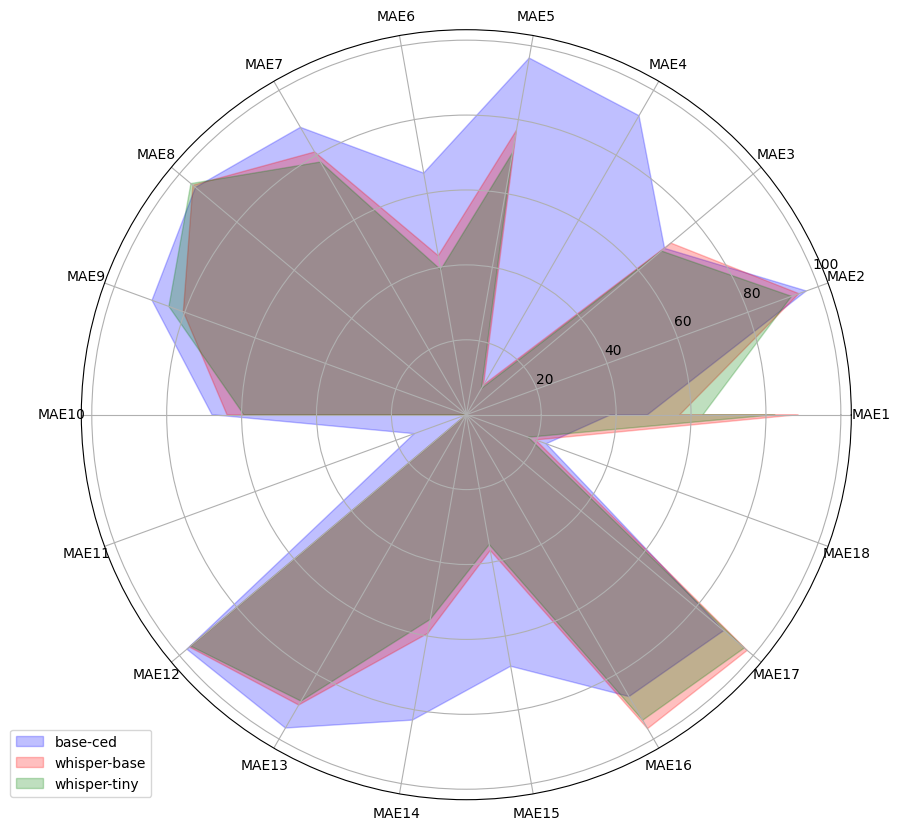

In [101]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the radar chart
labels = ['MAE1', 'MAE2', 'MAE3', 'MAE4', 'MAE5', 'MAE6', 'MAE7', 'MAE8', 'MAE9', 'MAE10',
          'MAE11', 'MAE12', 'MAE13', 'MAE14', 'MAE15', 'MAE16', 'MAE17', 'MAE18']
values_base_ced = [48.4, 96.6, 69.1, 92.2, 96.7, 65.5, 88.6, 94.4, 89.3, 67.9, 14.8, 97.4, 96.6, 82.8, 68.2, 86.9, 89.7, 22.7, 38.6]
values_whisper_base = [57.0, 94.5, 71.3, 9.2, 77.1, 43.1, 81.0, 95.3, 80.4, 63.9, 0.0, 96.5, 89.5, 59.3, 36.8, 96.8, 97.9, 19.7, 88.7]
values_whisper_tiny = [63.2, 92.4, 68.0, 8.1, 71.0, 39.3, 77.9, 96.0, 84.5, 59.4, 0.0, 96.1, 88.3, 55.5, 35.2, 94.2, 96.9, 17.6, 82.5]
values_best = [87.8, 97.5, 75.2, 92.5, 96.1, 64.1, 96.7, 90.8, 99.2, 78.5, 46.9, 97.5, 94.1, 90.0, 87.8, 97.6, 97.8, 21.5, 72.2]

# Number of variables
num_vars = len(labels)

# Calculate angles for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Close the plot
values_base_ced += values_base_ced[:0]
values_whisper_base += values_whisper_base[:0]
values_whisper_tiny += values_whisper_tiny[:0]
values_best += values_best[:0]
angles += angles[:1]

# Plotting the radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
ax.fill(angles, values_base_ced, color='b', alpha=0.25, label='base-ced')
ax.fill(angles, values_whisper_base, color='r', alpha=0.25, label='whisper-base')
ax.fill(angles, values_whisper_tiny, color='g', alpha=0.25, label='whisper-tiny')
# ax.fill(angles, values_best, color='purple', alpha=0.25, label='BEST')

# Set labels for each axis
ax.set_thetagrids(np.degrees(angles[:-1]), labels)

# Add a legend
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Show the plot
plt.show()